In [2]:
import torch
import os
from torch.autograd import Function
from torch.nn.modules.module import Module
import torch.nn as nn
from torch.autograd import Variable
import os
os.environ['PYTHON_EGG_CACHE'] = 'tmp/' # a writable directory 
import numpy as np
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image

if (torch.cuda.is_available()):
    device = "cuda"
elif (torch.backends.mps.is_available()):
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class correlation(nn.Module):
    """
    2D Correlation layer.
    For each spatial location in input1, this layer computes the patch-wise dot product
    between a patch from input1 and patches from input2 at a range of displacements.
    """
    def __init__(self, pad_size=3, kernel_size=3, max_displacement=20, stride1=1, stride2=1, corr_multiply=1):
        super(correlation, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def forward(self, input1, input2):
        # Pad both inputs
        input1_pad = F.pad(input1, (self.pad_size, self.pad_size, self.pad_size, self.pad_size))
        input2_pad = F.pad(input2, (self.pad_size, self.pad_size, self.pad_size, self.pad_size))

        # Compute output spatial size
        # (Assuming stride1 is used for the sliding window over input1)
        H = input1_pad.size(2)
        W = input1_pad.size(3)
        H_out = (H - self.kernel_size) // self.stride1 + 1
        W_out = (W - self.kernel_size) // self.stride1 + 1

        # Use unfold to extract sliding patches from input1.
        # patches1 shape: [batch, channels*kernel_size*kernel_size, L] where L = H_out*W_out.
        patches1 = F.unfold(input1_pad, kernel_size=self.kernel_size, stride=self.stride1)
        batch_size = patches1.size(0)
        L = patches1.size(2)

        # Number of displacement positions (both vertical and horizontal)
        disp_range = range(-self.max_displacement, self.max_displacement + 1, self.stride2)
        num_disp = len(disp_range) ** 2

        output = []
        # Loop over displacements (dy, dx)
        for dy in disp_range:
            for dx in disp_range:
                # Shift input2 using torch.roll.
                shifted_input2 = torch.roll(input2_pad, shifts=(dy, dx), dims=(2, 3))
                # Extract patches from shifted input2 (same parameters as for input1).
                patches2 = F.unfold(shifted_input2, kernel_size=self.kernel_size, stride=self.stride1)
                # Compute patch-wise dot product (correlation) along the patch dimension.
                # This yields a tensor of shape [batch, L].
                corr = (patches1 * patches2).sum(dim=1)
                # Reshape into [batch, 1, H_out, W_out] and collect it.
                output.append(corr.view(batch_size, 1, H_out, W_out))

        # Concatenate all displacements along the channel dimension and apply multiplication factor.
        output = torch.cat(output, dim=1) * self.corr_multiply
        return output


class correlation1d(nn.Module):
    """
    1D Correlation layer (often used for stereo disparity).
    Here, we compute correlation along the horizontal (x) axis only.
    """
    def __init__(self, pad_size=3, kernel_size=3, max_displacement=20, stride1=1, stride2=1, corr_multiply=1):
        super(correlation1d, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def forward(self, input1, input2):
        # Pad both inputs (using the same padding on all sides)
        input1_pad = F.pad(input1, (self.pad_size, self.pad_size, self.pad_size, self.pad_size))
        input2_pad = F.pad(input2, (self.pad_size, self.pad_size, self.pad_size, self.pad_size))

        # Compute output spatial size
        H = input1_pad.size(2)
        W = input1_pad.size(3)
        H_out = (H - self.kernel_size) // self.stride1 + 1
        W_out = (W - self.kernel_size) // self.stride1 + 1

        # Extract patches from input1.
        patches1 = F.unfold(input1_pad, kernel_size=self.kernel_size, stride=self.stride1)
        batch_size = patches1.size(0)
        L = patches1.size(2)

        # For 1D correlation, consider only horizontal displacements.
        disp_range = range(-self.max_displacement, self.max_displacement + 1, self.stride2)
        output = []
        for dx in disp_range:
            # For disparity, we do not shift vertically (dy = 0)
            shifted_input2 = torch.roll(input2_pad, shifts=(0, dx), dims=(2, 3))
            patches2 = F.unfold(shifted_input2, kernel_size=self.kernel_size, stride=self.stride1)
            corr = (patches1 * patches2).sum(dim=1)
            output.append(corr.view(batch_size, 1, H_out, W_out))
        output = torch.cat(output, dim=1) * self.corr_multiply
        return output

# -----------------------------


In [4]:
from torch.nn.modules.module import Module

class Correlation(Module):

    def __init__(self, pad_size=None, kernel_size=None, max_displacement=None,
                 stride1=None, stride2=None, corr_multiply=None):
        super(Correlation, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def reset_params(self):
        return

    def forward(self, input1, input2):
        return correlation(self.pad_size, self.kernel_size, self.max_displacement, self.stride1, self.stride2, self.corr_multiply)(input1, input2)

    def __repr__(self):
        return self.__class__.__name__


#----- correlation in 1D (for disparity) Jinwei Gu -----

class Correlation1d(Module):

    def __init__(self, pad_size=None, kernel_size=None, max_displacement=None,
                 stride1=None, stride2=None, corr_multiply=None):
        super(Correlation1d, self).__init__()
        self.pad_size = pad_size
        self.kernel_size = kernel_size
        self.max_displacement = max_displacement
        self.stride1 = stride1
        self.stride2 = stride2
        self.corr_multiply = corr_multiply

    def reset_params(self):
        return

    def forward(self, input1, input2):
        return correlation1d(self.pad_size, self.kernel_size, self.max_displacement, self.stride1, self.stride2, self.corr_multiply)(input1, input2)

    def __repr__(self):
        return self.__class__.__name__


In [5]:
def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1):   
    return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, 
                        padding=padding, dilation=dilation, bias=True),
            nn.LeakyReLU(0.1))

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=True)

def deconv(in_planes, out_planes, kernel_size=4, stride=2, padding=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=True)

In [6]:
class PWCDCNet(nn.Module):
    """
    PWC-DC net. add dilation convolution and densenet connections

    """
    def __init__(self, md=4):
        """
        input: md --- maximum displacement (for correlation. default: 4), after warpping

        """
        super(PWCDCNet,self).__init__()

        self.conv1a  = conv(3,   16, kernel_size=3, stride=2)
        self.conv1aa = conv(16,  16, kernel_size=3, stride=1)
        self.conv1b  = conv(16,  16, kernel_size=3, stride=1)
        self.conv2a  = conv(16,  32, kernel_size=3, stride=2)
        self.conv2aa = conv(32,  32, kernel_size=3, stride=1)
        self.conv2b  = conv(32,  32, kernel_size=3, stride=1)
        self.conv3a  = conv(32,  64, kernel_size=3, stride=2)
        self.conv3aa = conv(64,  64, kernel_size=3, stride=1)
        self.conv3b  = conv(64,  64, kernel_size=3, stride=1)
        self.conv4a  = conv(64,  96, kernel_size=3, stride=2)
        self.conv4aa = conv(96,  96, kernel_size=3, stride=1)
        self.conv4b  = conv(96,  96, kernel_size=3, stride=1)
        self.conv5a  = conv(96, 128, kernel_size=3, stride=2)
        self.conv5aa = conv(128,128, kernel_size=3, stride=1)
        self.conv5b  = conv(128,128, kernel_size=3, stride=1)
        self.conv6aa = conv(128,196, kernel_size=3, stride=2)
        self.conv6a  = conv(196,196, kernel_size=3, stride=1)
        self.conv6b  = conv(196,196, kernel_size=3, stride=1)

        self.corr    = Correlation(pad_size=md, kernel_size=1, max_displacement=md, stride1=1, stride2=1, corr_multiply=1)
        self.leakyRELU = nn.LeakyReLU(0.1)
        
        nd = (2*md+1)**2
        dd = np.cumsum([128,128,96,64,32])

        od = nd
        self.conv6_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv6_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv6_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv6_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv6_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)        
        self.predict_flow6 = predict_flow(od+dd[4])
        self.deconv6 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat6 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+128+4
        self.conv5_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv5_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv5_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv5_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv5_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow5 = predict_flow(od+dd[4]) 
        self.deconv5 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat5 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+96+4
        self.conv4_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv4_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv4_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv4_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv4_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow4 = predict_flow(od+dd[4]) 
        self.deconv4 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat4 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+64+4
        self.conv3_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv3_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv3_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv3_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv3_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow3 = predict_flow(od+dd[4]) 
        self.deconv3 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        self.upfeat3 = deconv(od+dd[4], 2, kernel_size=4, stride=2, padding=1) 
        
        od = nd+32+4
        self.conv2_0 = conv(od,      128, kernel_size=3, stride=1)
        self.conv2_1 = conv(od+dd[0],128, kernel_size=3, stride=1)
        self.conv2_2 = conv(od+dd[1],96,  kernel_size=3, stride=1)
        self.conv2_3 = conv(od+dd[2],64,  kernel_size=3, stride=1)
        self.conv2_4 = conv(od+dd[3],32,  kernel_size=3, stride=1)
        self.predict_flow2 = predict_flow(od+dd[4]) 
        self.deconv2 = deconv(2, 2, kernel_size=4, stride=2, padding=1) 
        
        self.dc_conv1 = conv(od+dd[4], 128, kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv2 = conv(128,      128, kernel_size=3, stride=1, padding=2,  dilation=2)
        self.dc_conv3 = conv(128,      128, kernel_size=3, stride=1, padding=4,  dilation=4)
        self.dc_conv4 = conv(128,      96,  kernel_size=3, stride=1, padding=8,  dilation=8)
        self.dc_conv5 = conv(96,       64,  kernel_size=3, stride=1, padding=16, dilation=16)
        self.dc_conv6 = conv(64,       32,  kernel_size=3, stride=1, padding=1,  dilation=1)
        self.dc_conv7 = predict_flow(32)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal(m.weight.data, mode='fan_in')
                if m.bias is not None:
                    m.bias.data.zero_()


    def warp(self, x, flo):
        """
        Warp an image/tensor (x) according to the optical flow (flo).

        x: [B, C, H, W] tensor to be warped.
        flo: [B, 2, H_f, W_f] optical flow that will be resized to match x.
        """
        B, C, H, W = x.size()
        device = x.device

        # Create a mesh grid of pixel coordinates
        xx = torch.arange(0, W, device=device).view(1, -1).repeat(H, 1)
        yy = torch.arange(0, H, device=device).view(-1, 1).repeat(1, W)
        xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
        yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
        grid = torch.cat((xx, yy), dim=1).float()  # shape: [B, 2, H, W]

        # Always interpolate the flow to match x's spatial size
        flo = torch.nn.functional.interpolate(flo, size=(H, W), mode='bilinear', align_corners=True)

        # Add flow to grid coordinates
        vgrid = grid + flo

        # Normalize grid coordinates to [-1, 1] for grid_sample
        vgrid_x = 2.0 * vgrid[:, 0, :, :] / max(W - 1, 1) - 1.0
        vgrid_y = 2.0 * vgrid[:, 1, :, :] / max(H - 1, 1) - 1.0
        vgrid = torch.stack((vgrid_x, vgrid_y), dim=3)  # shape: [B, H, W, 2]

        # Warp the input x using grid_sample
        output = torch.nn.functional.grid_sample(x, vgrid, align_corners=True)

        # Create a mask for valid coordinates
        mask = torch.ones_like(x, device=device)
        mask = torch.nn.functional.grid_sample(mask, vgrid, align_corners=True)
        mask[mask < 0.9999] = 0
        mask[mask > 0] = 1

        return output * mask




    def forward(self,x):
        

        im1 = x[:,:3,:,:]
        im2 = x[:,3:,:,:]
        
        c11 = self.conv1b(self.conv1aa(self.conv1a(im1)))
        c21 = self.conv1b(self.conv1aa(self.conv1a(im2)))
        c12 = self.conv2b(self.conv2aa(self.conv2a(c11)))
        c22 = self.conv2b(self.conv2aa(self.conv2a(c21)))
        c13 = self.conv3b(self.conv3aa(self.conv3a(c12)))
        c23 = self.conv3b(self.conv3aa(self.conv3a(c22)))
        c14 = self.conv4b(self.conv4aa(self.conv4a(c13)))
        c24 = self.conv4b(self.conv4aa(self.conv4a(c23)))
        c15 = self.conv5b(self.conv5aa(self.conv5a(c14)))
        c25 = self.conv5b(self.conv5aa(self.conv5a(c24)))
        c16 = self.conv6b(self.conv6a(self.conv6aa(c15)))
        c26 = self.conv6b(self.conv6a(self.conv6aa(c25)))


        corr6 = self.corr(c16, c26) 
        corr6 = self.leakyRELU(corr6)   


        x = torch.cat((self.conv6_0(corr6), corr6),1)
        x = torch.cat((self.conv6_1(x), x),1)
        x = torch.cat((self.conv6_2(x), x),1)
        x = torch.cat((self.conv6_3(x), x),1)
        x = torch.cat((self.conv6_4(x), x),1)
        flow6 = self.predict_flow6(x)
        up_flow6 = self.deconv6(flow6)
        up_feat6 = self.upfeat6(x)

        
        warp5 = self.warp(c25, up_flow6*0.625)
        corr5 = self.corr(c15, warp5) 
        corr5 = self.leakyRELU(corr5)
        import torch.nn.functional as F

# Assuming these shapes:
# corr5: [1, 81, 20, 22]
# c15: [1, 128, 12, 14]
# up_flow6: [1, 2, 28, 30]
# up_feat6: [1, 2, 28, 30]

        target_size = corr5.shape[2:]  # (20, 22)

        # Resize other tensors to match the target spatial dimensions
        c15_resized = F.interpolate(c15, size=target_size, mode='bilinear', align_corners=True)
        up_flow6_resized = F.interpolate(up_flow6, size=target_size, mode='bilinear', align_corners=True)
        up_feat6_resized = F.interpolate(up_feat6, size=target_size, mode='bilinear', align_corners=True)


        x = torch.cat((corr5, c15_resized, up_flow6_resized, up_feat6_resized), 1)
        x = torch.cat((self.conv5_0(x), x),1)
        x = torch.cat((self.conv5_1(x), x),1)
        x = torch.cat((self.conv5_2(x), x),1)
        x = torch.cat((self.conv5_3(x), x),1)
        x = torch.cat((self.conv5_4(x), x),1)
        flow5 = self.predict_flow5(x)
        up_flow5 = self.deconv5(flow5)
        up_feat5 = self.upfeat5(x)

       
        warp4 = self.warp(c24, up_flow5*1.25)
        corr4 = self.corr(c14, warp4)  
        corr4 = self.leakyRELU(corr4)
        target_size = corr4.shape[2:]  # (expected height, width)
        c14_resized      = F.interpolate(c14, size=target_size, mode='bilinear', align_corners=True)
        up_flow5_resized = F.interpolate(up_flow5, size=target_size, mode='bilinear', align_corners=True)
        up_feat5_resized = F.interpolate(up_feat5, size=target_size, mode='bilinear', align_corners=True)

        # Concatenate along the channel dimension
        x = torch.cat((corr4, c14_resized, up_flow5_resized, up_feat5_resized), 1)
        x = torch.cat((self.conv4_0(x), x),1)
        x = torch.cat((self.conv4_1(x), x),1)
        x = torch.cat((self.conv4_2(x), x),1)
        x = torch.cat((self.conv4_3(x), x),1)
        x = torch.cat((self.conv4_4(x), x),1)
        flow4 = self.predict_flow4(x)
        up_flow4 = self.deconv4(flow4)
        up_feat4 = self.upfeat4(x)


        warp3 = self.warp(c23, up_flow4*2.5)
        corr3 = self.corr(c13, warp3) 
        corr3 = self.leakyRELU(corr3)
        target_size = corr3.shape[2:]  # Use corr3's height and width as the target

        c13_resized      = F.interpolate(c13, size=target_size, mode='bilinear', align_corners=True)
        up_flow4_resized = F.interpolate(up_flow4, size=target_size, mode='bilinear', align_corners=True)
        up_feat4_resized = F.interpolate(up_feat4, size=target_size, mode='bilinear', align_corners=True)

        x = torch.cat((corr3, c13_resized, up_flow4_resized, up_feat4_resized), 1)

        
        x = torch.cat((self.conv3_0(x), x),1)
        x = torch.cat((self.conv3_1(x), x),1)
        x = torch.cat((self.conv3_2(x), x),1)
        x = torch.cat((self.conv3_3(x), x),1)
        x = torch.cat((self.conv3_4(x), x),1)
        flow3 = self.predict_flow3(x)
        up_flow3 = self.deconv3(flow3)
        up_feat3 = self.upfeat3(x)


        warp2 = self.warp(c22, up_flow3*5.0) 
        corr2 = self.corr(c12, warp2)
        corr2 = self.leakyRELU(corr2)
        target_size = corr2.shape[2:]  # Use corr2's spatial dimensions as the target

        c12_resized      = F.interpolate(c12, size=target_size, mode='bilinear', align_corners=True)
        up_flow3_resized = F.interpolate(up_flow3, size=target_size, mode='bilinear', align_corners=True)
        up_feat3_resized = F.interpolate(up_feat3, size=target_size, mode='bilinear', align_corners=True)

        x = torch.cat((corr2, c12_resized, up_flow3_resized, up_feat3_resized), 1)
        
        x = torch.cat((self.conv2_0(x), x),1)
        x = torch.cat((self.conv2_1(x), x),1)
        x = torch.cat((self.conv2_2(x), x),1)
        x = torch.cat((self.conv2_3(x), x),1)
        x = torch.cat((self.conv2_4(x), x),1)
        flow2 = self.predict_flow2(x)
 
        x = self.dc_conv4(self.dc_conv3(self.dc_conv2(self.dc_conv1(x))))
        flow2 = flow2 + self.dc_conv7(self.dc_conv6(self.dc_conv5(x)))
        
        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

In [7]:
# Instantiate the model
model = PWCDCNet()

# Load the checkpoint with weights_only=True
checkpoint = torch.load(
    "PyTorch/pwc_net.pth.tar",
    map_location=device,
    weights_only=True  # Prevents untrusted pickle execution (Recommended)
)

# Load state_dict into model
model.load_state_dict(checkpoint)

# Move model to CUDA if available
model.to(device)

# Set model to evaluation mode
model.eval()


/var/folders/6j/f2lgwpsj3s124b4pqjz_g_qm0000gn/T/ipykernel_91348/3472821127.py:97: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

In [8]:
from PIL import Image
import torch
import torchvision.transforms as transforms

frame1_path = "PyTorch/data/frame_0010.png"
frame2_path = "PyTorch/data/frame_0011.png"

# Load images and check mode
img1 = Image.open(frame1_path).convert("RGB")
img2 = Image.open(frame2_path).convert("RGB")
print("Image 1 Mode:", img1.mode, "Size:", img1.size)
print("Image 2 Mode:", img2.mode, "Size:", img2.size)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((384, 448)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to tensor
])

# Apply transformations
img1_tensor = transform(img1).unsqueeze(0).to(device)  # [1, 3, 384, 448]
img2_tensor = transform(img2).unsqueeze(0).to(device)  # [1, 3, 384, 448]

# Check tensor shapes
print("Image 1 Tensor Shape:", img1_tensor.shape)
print("Image 2 Tensor Shape:", img2_tensor.shape)

# Stack images along the channel dimension
input_tensor = torch.cat((img1_tensor, img2_tensor), dim=1)  # [1, 6, 384, 448]
print("Final Input Tensor Shape:", input_tensor.shape)  # Expected: [1, 6, 384, 448]

# Move to correct device
input_tensor = input_tensor.to(device)


Image 1 Mode: RGB Size: (1024, 436)
Image 2 Mode: RGB Size: (1024, 436)
Image 1 Tensor Shape: torch.Size([1, 3, 384, 448])
Image 2 Tensor Shape: torch.Size([1, 3, 384, 448])
Final Input Tensor Shape: torch.Size([1, 6, 384, 448])


In [9]:
output = model(input_tensor)

/var/folders/6j/f2lgwpsj3s124b4pqjz_g_qm0000gn/T/ipykernel_91348/3472821127.py:136: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:401.)
  mask[mask < 0.9999] = 0


In [10]:
output = torch.reshape(output, (2, 104, 120))

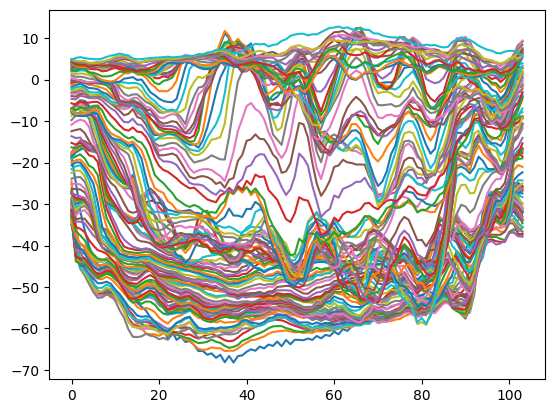

In [11]:
plt.plot(output[0].detach().cpu().numpy())
plt.show()